In [1]:
!ls

classifiers_mhcld.ipynb
codebook_descriptions.pickle
deep_learning.ipynb
google_colab_t-sne_mental_health_client-level_data.ipynb
mhcld_puf_2021.csv
plots
t-sne_k-means_mhcld.ipynb
to_do.txt
unsupervised_learning.ipynb


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
NUM_POINTS = 100_000
data = pd.read_csv("mhcld_puf_2021.csv")
data = data[:NUM_POINTS]

In [23]:
# Load data the codebook descriptions
import pickle
with open('codebook_descriptions.pickle', 'rb') as handle:
    codebook_descriptions = pickle.load(handle)
assert set(list(data.columns)) == set(list(codebook_descriptions.keys()))

In [24]:
#columns to drop. reasoning in t-sne notebook.
drop_cols = ['YEAR','CASEID','MH1','MH2','MH3','SMISED','DETNLF','NUMMHS','STATEFIP','REGION','DIVISION']
data = data.drop(columns = drop_cols)

In [25]:
#disorder columns. 0/1 binary. these are dignoses for the disorders
disorder_cols = ['SUB','TRAUSTREFLG','ANXIETYFLG','ADHDFLG','CONDUCTFLG','DELIRDEMFLG','BIPOLARFLG','DEPRESSFLG','ODDFLG','PDDFLG','SCHIZOFLG','PERSONFLG','ALCSUBFLG','OTHERDISFLG']

In [26]:
#columns which require a transformation to standardize to 0-1. reasoning in t-sne notebook.
transform_cols = ['AGE','EDUC','GENDER','SPHSERVICE','CMPSERVICE','OPISERVICE','RTCSERVICE','IJSSERVICE','SAP','VETERAN ']
max_age = max(data['AGE'])
max_educ = max(data['EDUC'])
data['AGE'] = data['AGE'].apply(lambda x: x/max_age)
data['EDUC'] = data['EDUC'].apply(lambda x: 0 if x==-9 else x/max_educ)
data['GENDER'] = data['GENDER'].apply(lambda x: .5 if x==-9 else x-1)
data['SAP'] = data['SAP'].apply(lambda x: .5 if x==-9 else x-1)
data['VETERAN'] = data['VETERAN'].apply(lambda x: .5 if x==-9 else x-1)
data['SUB'] = data['SUB'].apply(lambda x: 0 if x==-9 else 1)
data['SPHSERVICE'] = data['SPHSERVICE'].apply(lambda x: x-1)
data['CMPSERVICE'] = data['CMPSERVICE'].apply(lambda x: x-1)
data['OPISERVICE'] = data['OPISERVICE'].apply(lambda x: x-1)
data['RTCSERVICE'] = data['RTCSERVICE'].apply(lambda x: x-1)
data['IJSSERVICE'] = data['IJSSERVICE'].apply(lambda x: x-1)

In [27]:
#categorical columns w/ more than two categorices
#encode them with one-hot encoding
from sklearn.preprocessing import OneHotEncoder
one_hot_cols = ['ETHNIC','RACE','MARSTAT','EMPLOY','LIVARAG']
one_hot_enc=OneHotEncoder().fit(data[one_hot_cols])
one_hot_categorical_data = one_hot_enc.transform(data[one_hot_cols]).toarray()
one_hot_feature_names=list(one_hot_enc.get_feature_names_out(['ETHNIC','RACE','MARSTAT','EMPLOY','LIVARAG']))
one_hot_encoded_df = pd.DataFrame(data=one_hot_categorical_data,columns=one_hot_feature_names)
print(sum(len(item) for item in one_hot_enc.categories_))
data = data.drop(columns=one_hot_cols)
data = data.join(one_hot_encoded_df)
print(data.shape)

26
(100000, 50)


In [58]:
#create labels for the 13 disorder features
#binary encode them since they are 0/1
#take the total number of disorders present
#create unique leabel for each disorder, plus one for no disorder and one for multiple disorders
#use k-means to automatically label the clusters
from sklearn.cluster import KMeans
def get_labels(dataset, label_type='binary_encode',num_clusters=5):
    #generate labels using k-means
    if label_type == 'k-means':
        kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=300, random_state=0, n_init=10)
        kmeans.fit(dataset)
        return pd.DataFrame(kmeans.labels_,columns=['label'])
    labels = []
    for row in dataset[disorder_cols][:NUM_POINTS].itertuples():
        if label_type=='binary_encode':
            #binary number encoding of disorders
            encoding = ''.join([str(row[i]) for i in range(1,len(row))])
            labels.append(encoding)
        #sum the total number of disorders
        num_disorders = sum(row[i] for i in range(1,len(row)))
        if label_type == 'num_disorders':
            labels.append(num_disorders)
        #unique labels for pure disorders, separate categories for multiple or no disorders
        if label_type == 'unique_disorders':
            if num_disorders == 0:
                labels.append('no_disorder')
            if num_disorders == 1:
                #get the index (string) of the column with value 1
                labels.append(disorder_cols[list(row)[1:].index(1)])
            if num_disorders > 1:
                labels.append('multi-disorder')
    return pd.DataFrame(labels,columns=['label']) 

In [11]:
kmeans_label_df = get_labels(data,label_type='k-means',num_clusters=15)

In [59]:
binary_enc_label_df = get_labels(data,label_type='binary_encode')

In [13]:
unique_disorders_label_df = get_labels(data,label_type='unique_disorders')

In [60]:
binary_enc_label_df.value_counts()[:10]

label         
00000001000000    16041
00000000001000    11307
00010000000000     7543
01000000000000     7457
00000010000000     5639
00100000000000     5422
00100001000000     5407
00000000000001     4166
10000000001000     2701
10000001000000     2467
dtype: int64

In [13]:
#data_labeled = label_df.merge(data, left_index=True, right_index=True)
#tsne_results_kmeans_label = kmeans_label_df.merge(data, left_index=True, right_index=True)

In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, roc_auc_score, hamming_loss
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.multioutput import MultiOutputClassifier

In [15]:
#PERFORM RANDOM FOREST CLASSIFICATION
#may have unbalanced classes, too many in multi-disorder

In [61]:
#drop the disorder columns since we're trying to predict those
X = data.drop(columns=disorder_cols)
y = np.squeeze(binary_enc_label_df)

In [62]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [63]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [64]:
y_pred_rf = rf.predict(X_test)

In [65]:
#zero_division warning - unbalanced classes, i.e. multi-disorder has too many elements
#17% accuracy on multi-disorder-labeled data
#36% accuracy on unique-disorder-labeled data 
accuracy = accuracy_score(y_test, y_pred_rf)
print("Accuracy:", accuracy)
precision = precision_score(y_test, y_pred_rf, average='weighted')
print("Precision:", precision)
recall = recall_score(y_test, y_pred_rf, average='weighted')
print("Recall:", recall)

Accuracy: 0.25895
Precision: 0.18098683418841843
Recall: 0.25895


/Users/jacksonwalters/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jacksonwalters/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [66]:
vis_arr = multilabel_confusion_matrix(y_test, y_pred_rf)

In [67]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("CFS_MATRIX for " + class_label)

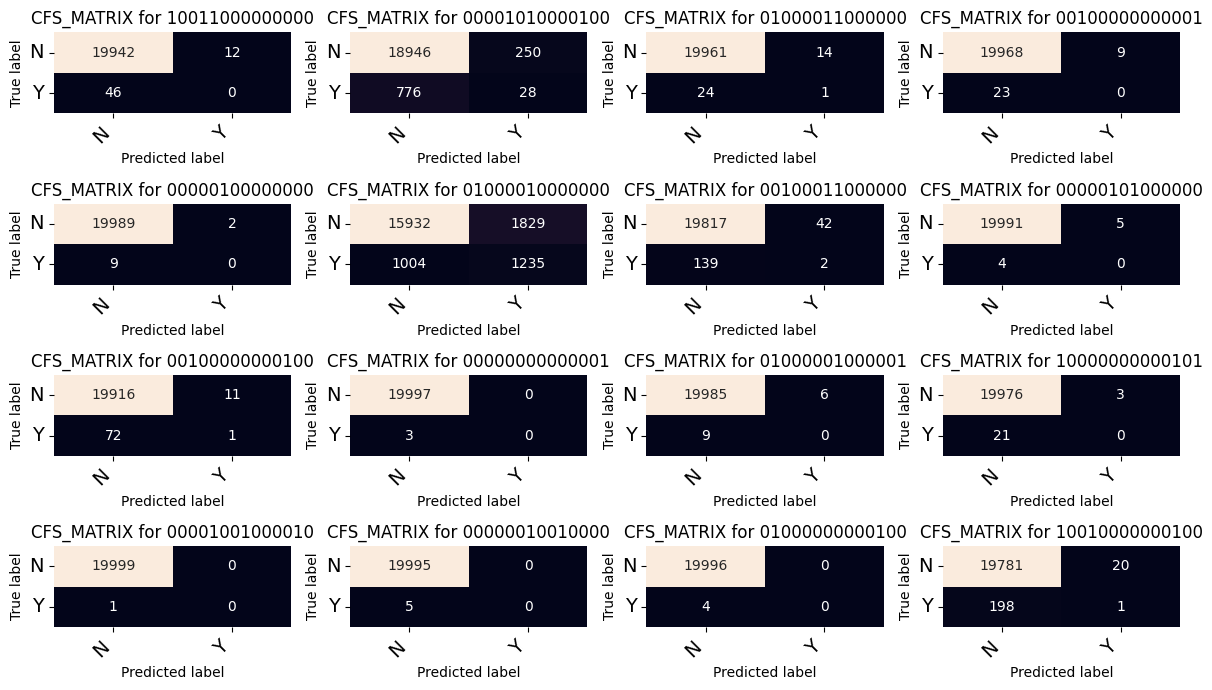

In [76]:
fig, ax = plt.subplots(4, 4, figsize=(12, 7))
    
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, list(set(y_test))):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    
fig.tight_layout()
fig.savefig("./plots/random_forest_confusion_matrix_mhcld_binary_enc-label.png")
plt.show()

In [24]:
#MULTI-CLASS LOGISTIC REGRESSION

In [77]:
#drop disorder cols, we are predicting those
#use unique_disorder labels
X = data.drop(columns=disorder_cols)
#y = np.squeeze(unique_disorders_label_df)
y = np.squeeze(binary_enc_label_df)

In [78]:
# Split the data into training and test sets
#stratified k-fold didn't help much
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [71]:
#fit the logistic regression model
clf = LogisticRegression(solver='lbfgs', max_iter=3000).fit(X_train, y_train)

In [72]:
#get predictions for logistic regression
y_pred_logistic = clf.predict(X_test)

In [73]:
#get accuracy, precision, recall scores
accuracy = accuracy_score(y_test, y_pred_logistic)
precision = precision_score(y_test, y_pred_logistic, average='weighted')
recall = recall_score(y_test, y_pred_logistic, average='weighted')
print(f"accuracy: {accuracy}")
print(f"precision: {precision}")
print(f"recall: {recall}")

accuracy: 0.2883
precision: 0.17213465356962485
recall: 0.2883


/Users/jacksonwalters/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jacksonwalters/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [74]:
#OUTPUT PROBABILITY VECTOR = [0-1, 0-1, ..., 0-1]
#get probabilities when the labels are one of the 13 labels from k-means
probabilities_logistic_binary_enc = clf.predict_proba(X_test)

In [75]:
probabilities_logistic_binary_enc[0]

array([1.20898868e-02, 2.45513881e-02, 5.08062683e-02, 8.78590573e-03,
       3.25529861e-04, 5.27510708e-03, 6.27580431e-05, 2.65555980e-04,
       1.87272959e-05, 1.30942605e-05, 1.70049218e-05, 5.39527383e-04,
       1.55932543e-06, 1.69320311e-06, 4.05346960e-06, 3.16325504e-05,
       1.56707374e-05, 2.69122377e-05, 3.11828816e-05, 6.68894317e-06,
       6.33892630e-06, 3.72131960e-06, 6.01769251e-06, 3.79467872e-06,
       6.60444093e-06, 1.81937692e-01, 5.14009077e-04, 5.62145691e-02,
       2.14427859e-04, 6.45188530e-04, 1.04683188e-04, 1.86577340e-05,
       9.70418979e-05, 5.10931183e-06, 4.57064532e-05, 1.84493673e-05,
       2.57926914e-05, 4.51243938e-06, 7.18329805e-06, 5.90054225e-05,
       1.48217801e-05, 2.47757151e-05, 4.09902090e-06, 6.96970603e-06,
       2.32743573e-02, 1.14330887e-04, 9.57675927e-05, 1.82968429e-04,
       1.11792120e-04, 8.12796416e-05, 3.14723057e-05, 6.25725691e-06,
       4.63739409e-05, 7.74612451e-06, 2.48420818e-06, 4.01700028e-06,
      

In [31]:
#PROBABILITIES OF INDIVIDUAL DISORDERS w/ LOGISTIC REGRESSION

In [42]:
#drop disorder cols, we are predicting those
#use unique_disorder labels
X = data.drop(columns=disorder_cols)
#y = np.squeeze(unique_disorders_label_df)
y = np.squeeze(data[disorder_cols])
#y = np.squeeze(binary_enc_label_df)

In [44]:
# Split the data into training and test sets
#stratified k-fold didn't help much
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [32]:
#drop disorder cols, we are predicting those
pred_each_disorder = []
X = data.drop(columns=disorder_cols)
for disorder in disorder_cols:
    #use unique_disorder labels
    #y = np.squeeze(unique_disorders_label_df)
    y = np.squeeze(data[disorder])
    #y = np.squeeze(binary_enc_label_df)
    # Split the data into training and test sets
    #stratified k-fold didn't help much
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    #fit the logistic regression model
    clf = LogisticRegression(solver='lbfgs', max_iter=3000).fit(X_train, y_train)
    #get predictions for binary logistic regression
    y_pred_logistic = clf.predict_proba(X_test)
    #only take the probabilties of predicting TRUE=1
    pred_each_disorder.append(y_pred_logistic[:, 1])

In [33]:
prediction_df = pd.DataFrame(np.array(pred_each_disorder).transpose(),columns=disorder_cols)

In [46]:
hamming_loss(y_test, round(prediction_df))

0.12171923076923077

In [35]:
#MULTI-OUTPUT MODEL

In [13]:
#drop disorder cols, we are predicting those
#use unique_disorder labels
X = data.drop(columns=disorder_cols)
#y = np.squeeze(unique_disorders_label_df)
y = np.squeeze(data[disorder_cols])
#y = np.squeeze(binary_enc_label_df)

In [14]:
# Split the data into training and test sets
#stratified k-fold didn't help much
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [50]:
multioutput_clf = MultiOutputClassifier(LogisticRegression(solver='lbfgs', max_iter=3000)).fit(X_train, y_train)

In [51]:
multioutput_pred = multioutput_clf.predict(X_test)

In [52]:
print('Hamming Loss: ', round(hamming_loss(y_test, multioutput_pred),2))

Hamming Loss:  0.1


In [48]:
#MULTI-LABEL CLASSIFIER

In [53]:
from sklearn.multiclass import OneVsRestClassifier

In [54]:
multilabel_clf=OneVsRestClassifier(LogisticRegression(solver='lbfgs', max_iter=3000)).fit(X_train, y_train)

In [55]:
multilabel_pred = multilabel_clf.predict(X_test)

In [56]:
from sklearn.metrics import hamming_loss
print('Hamming Loss: ', round(hamming_loss(y_test, multilabel_pred),2))

Hamming Loss:  0.1


In [2]:
#use scikit-multilearn

In [15]:
from skmultilearn.adapt import MLkNN

classifier = MLkNN(k=3)

# train
classifier.fit(np.array(X_train), np.array(y_train))

# predict
#predictions = classifier.predict(np.array(X_test))

MLkNN(k=3)

In [16]:
predictions = classifier.predict(np.array(X_test))

In [17]:
print('Hamming Loss: ', round(hamming_loss(y_test, predictions),2))

Hamming Loss:  0.11


In [1]:
#XG-BOOST CLASSIFIer

In [18]:
import xgboost as xgb
from sklearn.datasets import make_multilabel_classification

#drop disorder cols, we are predicting those
#use unique_disorder labels
X = data.drop(columns=disorder_cols)
#y = np.squeeze(unique_disorders_label_df)
y = np.squeeze(data[disorder_cols])
#y = np.squeeze(binary_enc_label_df)

In [19]:
# create sample dataset
#X, y = make_multilabel_classification(n_samples=3000, n_features=45, n_classes=20, n_labels=1,allow_unlabeled=False, random_state=42)

In [20]:
# split dataset into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [21]:
# create XGBoost instance with default hyper-parameters
xgb_estimator = xgb.XGBClassifier(objective='binary:logistic')

In [25]:
# create MultiOutputClassifier instance with XGBoost model inside
multilabel_model = MultiOutputClassifier(xgb_estimator)

In [26]:
# fit the model
multilabel_model.fit(X_train, y_train)

MultiOutputClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...))

In [28]:
xgboost_pred = multilabel_model.predict(X_test)

In [38]:
# evaluate on test data
print('Accuracy: {:.1f}%'.format(accuracy_score(y_test, xgboost_pred)*100))
print('Recall: {:.1f}%'.format(recall_score(y_test, xgboost_pred,average='weighted')*100))
print('Precision: {:.1f}%'.format(precision_score(y_test, xgboost_pred,average='weighted',zero_division=0)*100))
print('Hamming Loss: ', round(hamming_loss(y_test, xgboost_pred),2))

Accuracy: 17.2%
Recall: 19.8%
Precision: 46.8%
Hamming Loss:  0.1


In [2]:
#achieving at least 3% accuracy by direct comparison. accuracy may be using "subset" method
#significantly better performing than a random guess which would be 1/8192 = .01%
#Hamming loss is a little tricky. is it saying the Hamming distance beween y_test and y_pred is only .1?